In [1]:
!pip install datasets
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from datasets import Dataset


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00


In [2]:
data = pd.read_csv('data/CSE_584_Final_Dataset.csv')
print(data.head())

                              truncated_data  \
0            Ara will be interested when you   
1         As you know, all the medical units   
2     Till now no man there has lived beyond   
3          Maybe they got their radio turned   
4  So if somebody wanted to, say, track down   

                                      generated_data                 LLM  
0  Ara will be interested in learning more about ...    tinydolphin:1.1b  
1  can be converted to corresponding metric equiv...  mixtral-8x7b-32768  
2                                         the grave.           orca-mini  
3             up too loud, causing the interference.  mixtral-8x7b-32768  
4  potential leads or sources for a new business ...           orca-mini  


In [3]:
X_train_truncated, X_test_truncated, X_train_generated, X_test_generated = train_test_split(
    data['truncated_data'], data['generated_data'], test_size=0.2, random_state=70, shuffle=False
)

In [4]:
encode_labels = LabelEncoder()
data['numeric_label'] = encode_labels.fit_transform(data['LLM'])
label_mapping = dict(zip(encode_labels.classes_, encode_labels.transform(encode_labels.classes_)))

In [5]:
y_train, y_test = train_test_split(
    data['numeric_label'], test_size=0.2, random_state=70, shuffle=False
)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
MAX_SEQ_LEN = 128  # Adjust as needed based on data

def tokenize_pairs(xi, xj):
    xi = [str(text) for text in xi]
    xj = [str(text) for text in xj]

    encodings = tokenizer(
        xi,
        xj,
        add_special_tokens=True,
        max_length=MAX_SEQ_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encodings

In [8]:
train_encodings = tokenize_pairs(X_train_truncated.tolist(), X_train_generated.tolist())
test_encodings = tokenize_pairs(X_test_truncated.tolist(), X_test_generated.tolist())
print(train_encodings)
print(train_encodings)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[  101, 19027,  2097, ...,     0,     0,     0],
       [  101,  2004,  2017, ...,     0,     0,     0],
       [  101,  6229,  2085, ...,     0,     0,     0],
       ...,
       [  101,  1998,  2017, ...,     0,     0,     0],
       [  101,  1037,  2450, ...,     0,     0,     0],
       [  101,  2002,  2064, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(17210, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y_train
)).shuffle(len(X_train_truncated)).batch(32) # batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    y_test
)).batch(32)


In [12]:

num_labels = len(encode_labels.classes_)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Define optimizer, loss, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
EPOCHS = 4
trained_model = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/4
538/538 [==============================] - 511s 870ms/step - loss: 1.0776 - accuracy: 0.5550 - val_loss: 0.8050 - val_accuracy: 0.6865
Epoch 2/4
538/538 [==============================] - 468s 869ms/step - loss: 0.7185 - accuracy: 0.7239 - val_loss: 0.7229 - val_accuracy: 0.7121
Epoch 3/4
538/538 [==============================] - 467s 869ms/step - loss: 0.5083 - accuracy: 0.8109 - val_loss: 0.7376 - val_accuracy: 0.7218
Epoch 4/4
538/538 [==============================] - 470s 873ms/step - loss: 0.3340 - accuracy: 0.8801 - val_loss: 0.8162 - val_accuracy: 0.7174


In [14]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


135/135 [==============================] - 36s 264ms/step - loss: 0.8162 - accuracy: 0.7174
Test Loss: 0.8162214159965515
Test Accuracy: 0.7174064517021179


In [15]:
import matplotlib.pyplot as plt

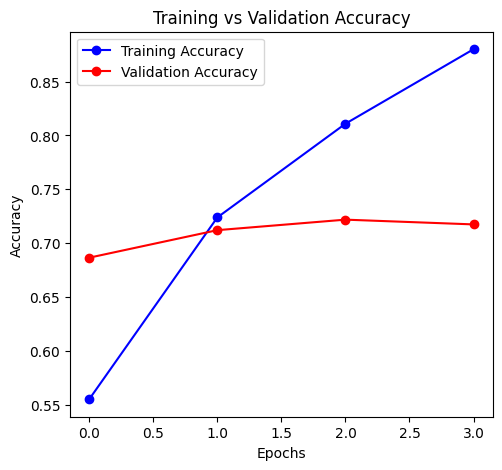

In [16]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(trained_model.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

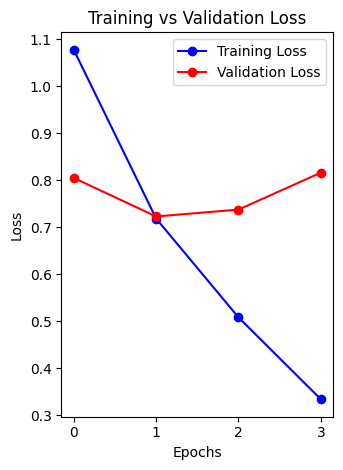

In [18]:
plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], 'bo-', label='Training Loss')
plt.plot(trained_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

135/135 [==============================] - 41s 264ms/step
(4303, 5)


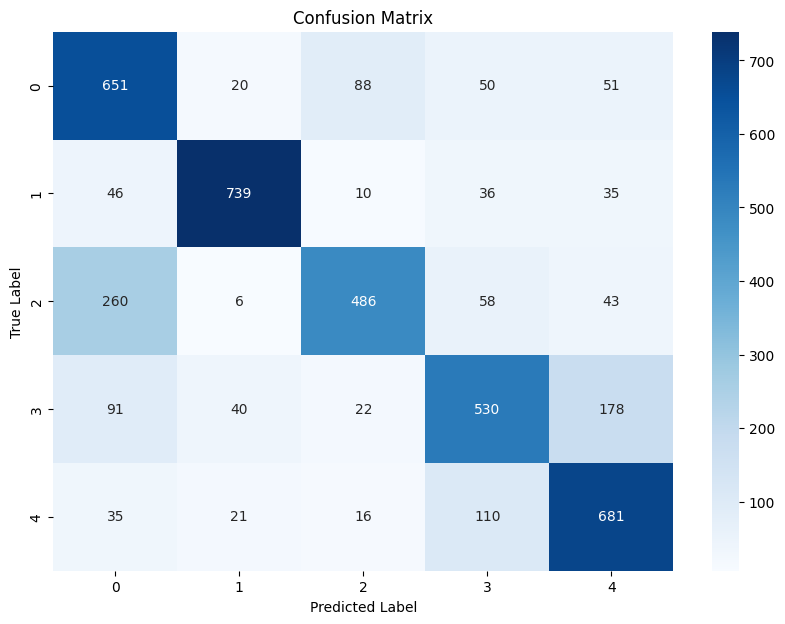

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf # Make sure to import tensorflow

# Assuming y_test and y_pred are your true labels and predicted labels
# Extract the logits (predicted probabilities)
# Now you can access the shape of the logits
# If y_pred_logits is 1D, use axis=0 for argmax

y_pred = model.predict(test_dataset)
y_pred_logits = y_pred.logits
print(y_pred_logits.shape)
y_pred_classes = np.argmax(y_pred_logits, axis=0) if y_pred_logits.ndim == 1 else np.argmax(y_pred_logits, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('bert')
tokenizer.save_pretrained('bert')

In [ ]:
# Save only the model weights
model.save_weights('bert')

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained('bert')

## Experiments

In [ ]:
EPOCHS = 2
trained_model = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)


Epoch 1/2
538/538 [==============================] - 462s 859ms/step - loss: 0.3015 - accuracy: 0.8924 - val_loss: 0.7994 - val_accuracy: 0.7309
Epoch 2/2
538/538 [==============================] - 461s 857ms/step - loss: 0.1782 - accuracy: 0.9383 - val_loss: 0.9744 - val_accuracy: 0.7248


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


135/135 [==============================] - 39s 285ms/step - loss: 0.9744 - accuracy: 0.7248
Test Loss: 0.974377453327179
Test Accuracy: 0.7248431444168091


In [ ]:
import matplotlib.pyplot as plt

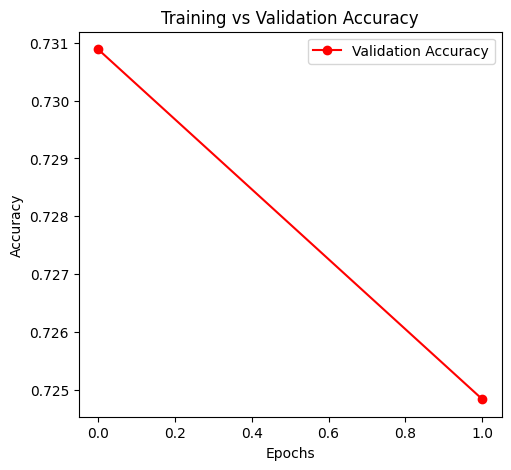

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
# plt.plot(trained_model.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(trained_model.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

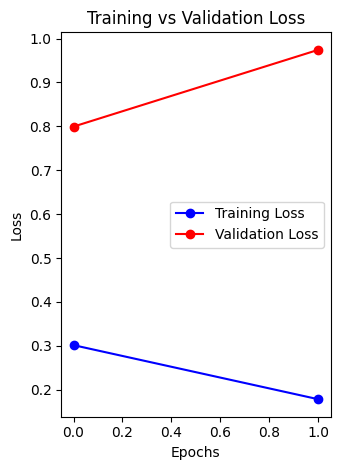

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(trained_model.history['loss'], 'bo-', label='Training Loss')
plt.plot(trained_model.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
EPOCHS = 4
trained_model_3 = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

Epoch 1/4
538/538 [==============================] - 462s 858ms/step - loss: 0.1165 - accuracy: 0.9597 - val_loss: 0.9794 - val_accuracy: 0.7332
Epoch 2/4
538/538 [==============================] - 461s 857ms/step - loss: 0.0870 - accuracy: 0.9721 - val_loss: 1.0943 - val_accuracy: 0.7279
Epoch 3/4
538/538 [==============================] - 464s 863ms/step - loss: 0.0667 - accuracy: 0.9779 - val_loss: 1.1251 - val_accuracy: 0.7339
Epoch 4/4
538/538 [==============================] - 462s 859ms/step - loss: 0.0534 - accuracy: 0.9833 - val_loss: 1.2028 - val_accuracy: 0.7374


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


135/135 [==============================] - 39s 285ms/step - loss: 1.2028 - accuracy: 0.7374
Test Loss: 1.2028440237045288
Test Accuracy: 0.7373925447463989


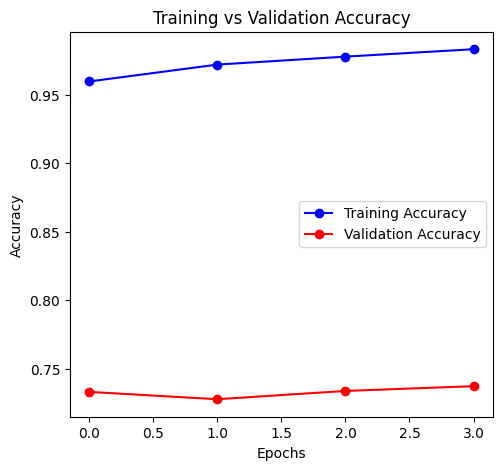

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(trained_model_3.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(trained_model_3.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

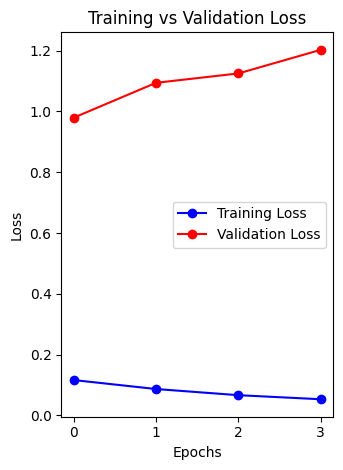

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(trained_model_3.history['loss'], 'bo-', label='Training Loss')
plt.plot(trained_model_3.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

135/135 [==============================] - 38s 284ms/step
(4303, 5)


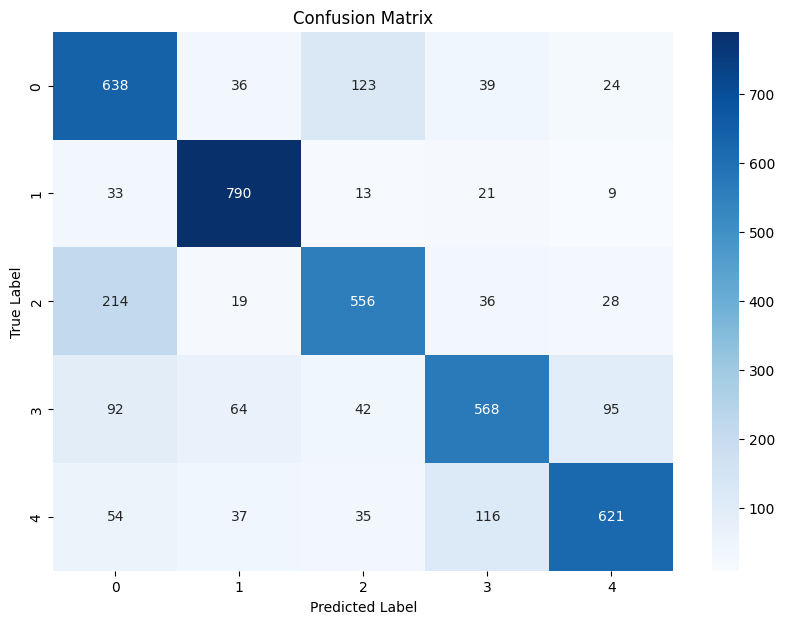

In [ ]:
y_pred = model.predict(test_dataset)
y_pred_logits = y_pred.logits
print(y_pred_logits.shape)
y_pred_classes = np.argmax(y_pred_logits, axis=0) if y_pred_logits.ndim == 1 else np.argmax(y_pred_logits, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

('bert/tokenizer_config.json',
 'bert/special_tokens_map.json',
 'bert/vocab.txt',
 'bert/added_tokens.json')

('distilbert/tokenizer_config.json',
 'distilbert/special_tokens_map.json',
 'distilbert/vocab.txt',
 'distilbert/added_tokens.json')